# Εργασία Αριθμητικής Ανάλυσης

Χατζηγρίβας Κωνσταντίνος 10552
Λιούτας Γιώργος          10974

## Συλλογή Δεδομένων

In [ ]:
import yfinance as yfin

stock = yfin.Ticker("GOOG")
history = stock.history(start = "2025-05-05", end = "2025-05-10", interval="30m")
history['Open'].to_csv('open_prices.csv', header=True)

print(history['Open'].head())

Datetime
2025-05-12 09:30:00-04:00    445.899994
2025-05-12 10:00:00-04:00    441.095001
2025-05-12 10:30:00-04:00    443.940002
2025-05-12 11:00:00-04:00    443.875000
2025-05-12 11:30:00-04:00    443.760010
Name: Open, dtype: float64


## Πολυωνυμική Προσαρμογή Ελαχίστων Τετραγώνων

In [65]:
import numpy as np

def get_poly(x, y, degree):
	coeffs = np.polyfit(x, y, degree)
	poly = np.poly1d(coeffs)
	return poly

data = history['Open'].values
data_x = np.arange(len(data))

split_index = int(len(data_x) * 0.8)
data_x_train = data_x[:split_index]
data_x_test = data_x[split_index:]
data_train = data[:split_index]
data_test = data[split_index:]

poly1=get_poly(data_x_train, data_train, 1)
poly2=get_poly(data_x_train, data_train, 2)
poly3=get_poly(data_x_train, data_train, 3)

MAE1=0.0
MAE2=0.0
MAE3=0.0
MSE1=0.0
MSE2 =0.0
MSE3=0.0

for i in range(0, len(data_x_test)):
	MAE1 += np.abs(poly1(data_x_test[i]) - data_test[i])
	MAE2 += np.abs(poly2(data_x_test[i]) - data_test[i])
	MAE3 += np.abs(poly3(data_x_test[i]) - data_test[i])
	MSE1 += (poly1(data_x_test[i]) - data_test[i])**2
	MSE2 += (poly2(data_x_test[i]) - data_test[i])**2
	MSE3 += (poly3(data_x_test[i]) - data_test[i])**2

MAE1 /= len(data_test)
MAE2 /= len(data_test)
MAE3 /= len(data_test)
MSE1 /= len(data_test)
MSE2 /= len(data_test)
MSE3 /= len(data_test)

print(f"1ou bathmou: MAE:{MAE1:.4f}, MSE:{MSE1:.4f}")
print(f"2ou bathmou: MAE:{MAE2:.4f}, MSE:{MSE2:.4f}")
print(f"3ou bathmou: MAE:{MAE3:.4f}, MSE:{MSE3:.4f}")


1ou bathmou: MAE:5.8970, MSE:35.7621
2ou bathmou: MAE:3.8092, MSE:15.8579
3ou bathmou: MAE:2.9545, MSE:10.7534


Άρα το καλύτερο μοντέλο είναι αυτό του χ βαθμού, και αυτό θα χρησιμοποιούμε από εδώ και πέρα.

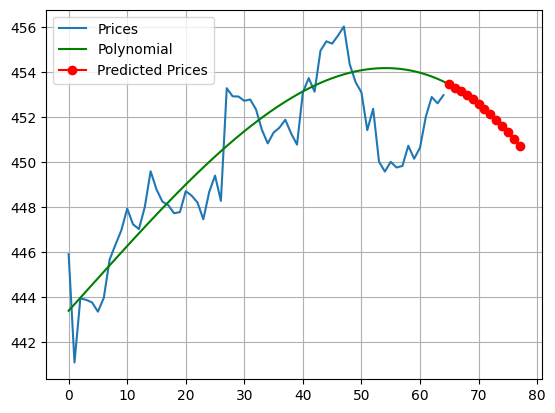

In [69]:
import matplotlib.pyplot as plot

x_pred = np.arange(len(data_x), len(data_x) + 13)

if MAE1 <= MAE2 and MAE1 <= MAE3:
	y_pred = poly1(x_pred)
elif MAE2 <= MAE3 and MAE2 <= MAE1:
	y_pred = poly2(x_pred)
else:
	y_pred = poly3(x_pred)

x_new = np.linspace(0, len(data_x) + 13 - 1, 1000)
y_new = poly3(x_new)

plot.plot(data_x, data, label="Prices")
plot.plot(x_new, y_new, label="Polynomial", color='green')
plot.plot(x_pred, y_pred, label="Predicted Prices", color='red', marker='o')
plot.legend()
plot.grid(True)
plot.show()

In [67]:
def trap_area(y, h = 1):
	area = 0
	for i in range(len(y) - 1):
		area += (y[i] + y[i + 1]) * h / 2
	return area

def simp_area(y):
	n = len(y)

	s = y[0] + y[n - 1]

	for i in range(1, n - 1):
		if i % 2 == 0:
			s += 2 * y[i]
		else:
			s += 4 * y[i]

	area = (1 / 3) * s
	return area

def get_area(poly, step, start, stop):
	x = np.linspace(start, stop, step)
	y = poly(x)
	h = (stop - start) / (step - 1)
	a = trap_area(y, h)
	a /= (stop - start)
	return a

a_simp = simp_area(data)
a_trap = trap_area(data)
m_simp = a_simp / len(data)
m_trap = a_trap / len(data)

print(f"Trapezoid: Area:{a_trap} Mean:{m_trap}")
print(f"Simpson: Area:{a_simp} Mean:{m_simp}")
print()
print(f"Degree 1 Area:{get_area(poly1, 100, 0, len(data))}")
print(f"Degree 2 Area:{get_area(poly2, 100, 0, len(data))}")
print(f"Degree 3 Area:{get_area(poly3, 100, 0, len(data))}")

Trapezoid: Area:28803.621704101562 Mean:443.1326416015625
Simpson: Area:28802.332010904945 Mean:443.1128001677684

Degree 1 Area:451.33605839851356
Degree 2 Area:450.9014250467642
Degree 3 Area:450.7154333891032


In [68]:
def aitken(x, y, val):
	arr = [[0 for _ in range(len(x))] for _ in range(len(x))]

	for i in range(len(x)):
		arr[i][0] = y[i]
	
	for j in range(1, len(x)):
		for i in range(j, len(x)):
			arr[i][j] = ((x[j - 1] - val) * arr[i][j - 1] - (x[i] - val) * arr[j - 1][j - 1]) / (x[j - 1] - x[i])
	
	return arr[len(x) - 1][len(x) - 1]

def n_divided(x, y, val):
	arr = [[0 for _ in range(len(x))] for _ in range(len(x))]

	for i in range(len(x)):
		arr[i][0] = y[i]

	for j in range(1, len(x)):
		for i in range(len(x) - j):
			arr[i][j] = (arr[i+1][j-1]-arr[i][j-1]) / (x[i+j]-x[i])
	
	coef = []
	for i in range(len(x)):
		coef.append(arr[0][i])

	r = coef[0]
	p = 1.0
	for i in range(1, len(coef)):
		p *= (val - x[i - 1])
		r += coef[i] * p
	return r

print("Prediction Values:")
for i in range(0, len(data_x) - 5, 5):
	new_x = data_x[i:i + 5]
	new_y = data[i:i + 5]
	x_targ = data_x[i + 5]
	y_targ = data[i + 5]
	aitken_res = aitken(new_x, new_y, x_targ)
	newton = n_divided(new_x, new_y, x_targ)

	print(f"x:{x_targ:2d}, y:{y_targ:.2f} -> Aitken:{aitken_res:.2f} Netwon:{newton:.2f} Aitken diff:{np.abs(aitken_res - y_targ):5.2f} Newton diff:{np.abs(newton - y_targ):5.2f}")

Prediction Values:
x: 5, y:443.35 -> Aitken:459.88 Netwon:459.88 Aitken diff:16.53 Newton diff:16.53
x:10, y:447.92 -> Aitken:451.77 Netwon:451.77 Aitken diff: 3.85 Newton diff: 3.85
x:15, y:448.78 -> Aitken:450.00 Netwon:450.00 Aitken diff: 1.22 Newton diff: 1.22
x:20, y:448.70 -> Aitken:450.03 Netwon:450.03 Aitken diff: 1.33 Newton diff: 1.33
x:25, y:449.39 -> Aitken:457.00 Netwon:457.00 Aitken diff: 7.61 Newton diff: 7.61
x:30, y:452.71 -> Aitken:476.14 Netwon:476.14 Aitken diff:23.43 Newton diff:23.43
x:35, y:451.30 -> Aitken:451.96 Netwon:451.96 Aitken diff: 0.66 Newton diff: 0.66
x:40, y:453.09 -> Aitken:453.62 Netwon:453.62 Aitken diff: 0.53 Newton diff: 0.53
x:45, y:455.25 -> Aitken:443.09 Netwon:443.09 Aitken diff:12.16 Newton diff:12.16
x:50, y:453.08 -> Aitken:461.73 Netwon:461.73 Aitken diff: 8.65 Newton diff: 8.65
x:55, y:450.00 -> Aitken:467.33 Netwon:467.33 Aitken diff:17.33 Newton diff:17.33
x:60, y:450.63 -> Aitken:443.00 Netwon:443.00 Aitken diff: 7.63 Newton diff: 7.